# The Rainbow Method Part II. Empirical Application.

- author: Anna Arakelyan, Dmytro Karabash
- categories: [python, data science, classification, encoding]
- image: ../images/rainbow2.jpg
- permalink: /rainbow2/
- hide: true

![rainbow](../images/rainbow2.jpg)

In [Part I](link) we discussed the advantages of ordinal encoding compared to One-hot for any categorical variables, when used with tree-based algorithms. We introduced the Rainbow method of identifying the most appropriate ordinal encoding for different types of categorical variables. 

Here in Part II, we continue exploring the Rainbow method, now from the empirical standpoint. We will illustrate the effectiveness of the Rainbow method using a real project developed in the [Data Science](https://datascience.massmutual.com) organization at [MassMutual](https://www.massmutual.com/) - a life insurance company with over 170 years of history. MassMutual proudly invests in a large team of data scientists, engineers, and technologists to inform critical business decisions.

## Business Use Case

The task is to predict one of five Mindset Segments for each prospective customer. Essentially, it is a multiclass classification problem.

Figure 1

<img align="left" src="img-anna/seg_framework.png" width="500">

This segmentation framework represents five classes that reflect a person's age, financial stability, and attitude towards financial decisions. The predicted segments are used by the MassMutual marketing team in different types of campaigns for targeting and customization. 

For example, Mindset A customers would value more independence and autonomy in deciding on buying a life insurance policy whereas Mindset B customers would value having guidance and thorough explanations of different financial products by a dedicated advisor.

We have a small set of labeled individuals (17.5K persons). The labels are provided by a MassMutual vendor who designed the segment assignment rules. We first attached columns from our main prospect database to this data. The goal is to learn the best model using these target labels and available features and then predict segments for all other (unlabeled) prospective customers.

The main database for this project is provided by [Acxiom](https://www.acxiom.com/) and covers about 300 columns representing a rich set of demographic characteristics, like composition of the household, propensities of income and net worth, predictions of financial behavior and digital savviness.

In [1]:
#hide

# Add 'rainbow_research.csv' and 'rainbow_research_feature_selection.csv' in the _notebooks folder
# Don't push data to repo - they must be ignored in .gitignore

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)


results = pd.read_csv('rainbow_research.csv').rename(columns={'feature_selection_parameter':'Num_features',"transform_parameter": "method"})
results['method']=results['method'].replace({'one_hot': "One-hot", 'rainbow': "Rainbow"})

size_of_data = int((results['n_train'] + results['n_test'])[0])
size_of_data

17493

Using Acxiom data and the Mindset Segmentation project, we will compare the conventional One-hot encoding with the ordinal encoding via the Rainbow method. For this 5-class classification task, we will demonstrate a few standard metrics - Accuracy, Cohen's Kappa, Macro Avg F1 score, and Macro Avg AUC ROC. Accuracy is used merely for interpretation and comparison purposes, while the rest of the metrics are very helpful for unbalanced multiclass classification problems.

## Categorical Variables

We took all the categorical variables in the Acxiom database - interval, ordinal, and nominal - and excluded quantitative and binary variables. The idea is to demonstrate the pure difference in model performance between the two types of encoding for the same set of categorical factors.

We then applied a target stratified 4-fold Cross-Validation split. All the data processing from this point on is done inside the cross-validation loop, i.e. the creation of One-hot features and Rainbow features is learned from each fold train set and applied to each fold validation set. 

The total set of **111** variables was transformed into **121** Rainbow features and, alternatively, into **2260** One-hot features (with very slight deviations in this number in 4 different folds).

Table 1

<style>
td {
  font-size: 18px
}
th {
  font-size: 18px
}
</style>

| Type of variable | N raw | N Rainbow encoded | N One-hot encoded |
| :-:| :-: | :-: | :-:|
| Interval |64| 64 | 1670 |
| Ordinal | 14 | 14 | 178 |
| Nominal |33| 43 | 412 |
| Total | 111 | **121** | **2260** |

While interval and ordinal variables have a straightforward rainbow transformation (one can notice that 64 interval features turned into 64 rainbows and 14 ordinal features turned into 14 rainbows) the nominal variables transformation was a bit more involved. Out of 33 nominal variables, for 23 we found a natural attribute rainbow, while for each of the 10 remaining variables we created 2 artificial rainbow features. Since we deal with 5 classes, we applied correlation ordering for a random class and target percent ordering for a random class (see [Part I](link)).

For example, for the original categorical variable "Financial_Cluster" we made features <br>*Financial_Cluster_Mindset_B_correlation_rank*
<br>and 
<br>*Financial_Cluster_Mindset_D_target_percent*

In this way, 33 raw nominal variables turned into 43 Rainbows. The search for the approach to make natural attribute rainbows or artificial rainbows is highly project and context-specific, and is more of an art than a science. We invite you to play with it and rely on model simplicity, performance, and interpretability when making final choice.

Unlike ordinal encoding, One-hot transformation generates over two thousand features. Why do we make One-hot features for interval and ordinal variables here? Because we want to compare Rainbow with One-hot on the full continuum of possible ordering - from perfect order to fuzzy order to no order (or wrong order). Also, sometimes the classification 
of a variable into ordinal or nominal is a subjective decision. 
> As we discussed in [Part I](link), Color is considered nominal by some modelers, and ordinal by other modelers. To be fair, from statistical standpoint, Color is nominal, but machine learning scientists might use Hue attribute to turn it into ordinal for modeling purposes.

At first, we pool all the categorical variables together. Later in the article, we separate interval, ordinal, and nominal variables and analyze their outcomes individually.

We ran all XGBoost models covering this hyperparameter space:
```
'objective': 'multi:softprob'
'eval_metric': 'mlogloss'
'num_class': 5
'subsample': 0.8
'max_depth': [2, 3, 5]
'eta': [0.1, 0.3, 0.5]
'n_estimators': [50, 100, 200]
```

We don't try maximum depth values higher than 5 because of the relatively small data size. The training data size reduces due to cross-validation split and XGBoost subsample parameter. If at the end of each branch we expect to have at least 100 samples, the max depth should be limited at about 5-6. Setting it at higher value would seriously complicate or overfit the model. And, especially for the goals of this analysis, we'd rather err on the side of simplicity. 

All the results below represent cross-validation average metrics.

## Aggregate Results 

Let us start with the overall averages across all runs. Clearly, the average metrics across all models are higher for Rainbow ordinal encoding. The overall difference is a few percentage points.

Figure 2

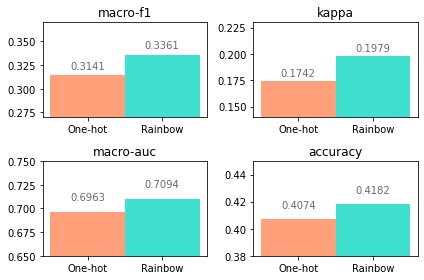

In [2]:
#hide_input
t=results.copy()
t=t.rename(columns={'macro avg_f1-score': 'macro-f1',
                       'macro avg_roc_auc':'macro-auc',
                      })
k = t[t['feature_group']=='all'].groupby(['method'])[['accuracy', 'kappa', 'macro-f1', 'macro-auc']].mean().round(4)

def autolabel(rects, i, j, decimals=3):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        axs[i, j].text(rect.get_x() + rect.get_width()/2., 1.015*height,
                '%.{}f'.format(decimals) % height,
                ha='center', va='bottom', color = 'dimgrey')  

def make_subplot2(k, metric, x, i, j, colors, ylimits=[]):
    y = k[metric]
    rects = axs[i, j].bar(x, y, color = colors, width=1, align='center')
    axs[i, j].set_ylim(ylimits)
    axs[i, j].set_xticks(x)    
    axs[i, j].set_xticklabels(['One-hot', 'Rainbow'])
    axs[i, j].set_title(metric)
    autolabel(rects, i, j, 4)


x = np.arange(2)
fig, axs = plt.subplots(2, 2)
colors = ['lightsalmon', 'turquoise']
make_subplot2(k, 'macro-f1', x, 0, 0, colors, [0.27,0.37])
make_subplot2(k, 'kappa', x, 0, 1, colors, [0.14, 0.23])
make_subplot2(k, 'macro-auc', x, 1, 0, colors, [0.65, 0.75])
make_subplot2(k, 'accuracy', x, 1, 1, colors, [0.38, 0.45])
fig.tight_layout()
plt.show()


## Hyperparameters

The following plots show metric dynamics for each hyperparameter keeping all other hyperparameters constant. These plots also clearly demonstrate that Rainbow outcomes exceed One-hot outcomes for each hyperparameter and each metric.

Figure 3

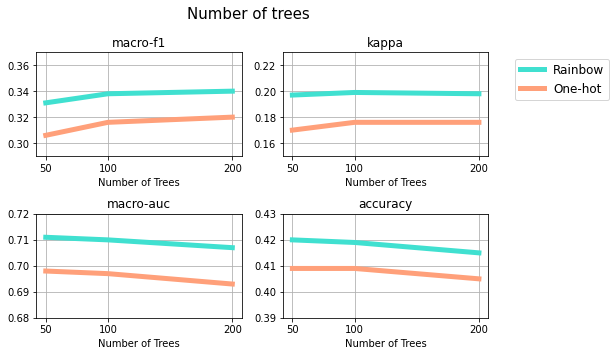

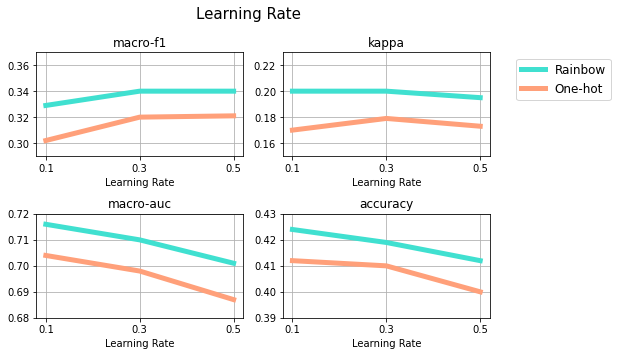

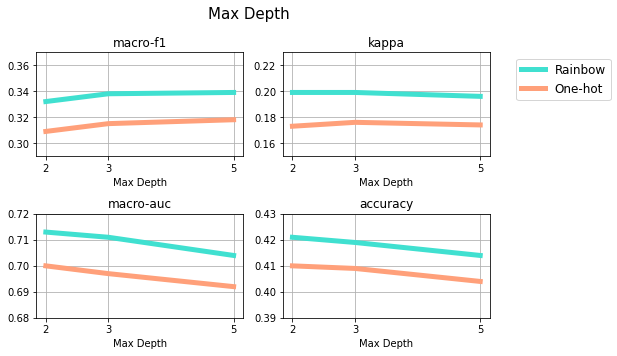

In [3]:
#hide_input

def make_subplot3(t, i, j, feature_group, hyperparameter, hyperparameter_name, metric, 
                  ylimit_bottom, ylimit_top, xticks_list):
    k1 = pd.DataFrame(t[t['feature_group']==feature_group][t['method']=='Rainbow'].groupby(
        hyperparameter)[metric].mean().round(3))
    k2 = pd.DataFrame(t[t['feature_group']==feature_group][t['method']=='One-hot'].groupby(
        hyperparameter)[metric].mean().round(3))
    ax = axs[i,j]
    k1[metric].plot(ax=ax, label = 'Rainbow', color=colors[1], linewidth=5)
    k2[metric].plot(ax=ax, label = 'One-hot', color = colors[0], linewidth=5)
    ax.set_ylim(ylimit_bottom, ylimit_top)
    ax.set_xticks(xticks_list)
    ax.grid()
    ax.set_xlabel(hyperparameter_name)
    ax.set_title(metric)



fig, axs = plt.subplots(2, 2, figsize = (7,5))
make_subplot3(t, 0, 0, 'all', 'n_trees', 'Number of Trees', 'macro-f1', 0.29, 0.37, [50, 100 ,200])
make_subplot3(t, 0, 1, 'all', 'n_trees', 'Number of Trees', 'kappa', 0.15, 0.23, [50, 100 ,200])
make_subplot3(t, 1, 0, 'all', 'n_trees', 'Number of Trees', 'macro-auc', 0.68, 0.72, [50, 100 ,200])
make_subplot3(t, 1, 1, 'all', 'n_trees', 'Number of Trees', 'accuracy', 0.39, 0.43, [50, 100 ,200])
fig.suptitle('Number of trees', fontsize=15)
fig.tight_layout()
plt.legend(bbox_to_anchor=(1.1, 2.55), loc='upper left', prop={'size': 12})
plt.show()

fig, axs = plt.subplots(2, 2, figsize = (7,5))
make_subplot3(t, 0, 0, 'all', 'eta', 'Learning Rate', 'macro-f1', 0.29, 0.37, [0.1, 0.3 ,0.5])
make_subplot3(t, 0, 1, 'all', 'eta', 'Learning Rate', 'kappa', 0.15, 0.23, [0.1, 0.3 ,0.5])
make_subplot3(t, 1, 0, 'all', 'eta', 'Learning Rate', 'macro-auc', 0.68, 0.72, [0.1, 0.3 ,0.5])
make_subplot3(t, 1, 1, 'all', 'eta', 'Learning Rate', 'accuracy', 0.39, 0.43, [0.1, 0.3 ,0.5])
fig.suptitle('Learning Rate', fontsize=15)
fig.tight_layout()
plt.legend(bbox_to_anchor=(1.1, 2.55), loc='upper left', prop={'size': 12})
plt.show()

fig, axs = plt.subplots(2, 2, figsize = (7,5))
make_subplot3(t, 0, 0, 'all',  'max_depth', 'Max Depth', 'macro-f1', 0.29, 0.37, [2, 3 ,5])
make_subplot3(t, 0, 1, 'all',  'max_depth', 'Max Depth', 'kappa', 0.15, 0.23, [2, 3 ,5])
make_subplot3(t, 1, 0, 'all',  'max_depth', 'Max Depth', 'macro-auc', 0.68, 0.72, [2, 3 ,5])
make_subplot3(t, 1, 1, 'all',  'max_depth', 'Max Depth', 'accuracy', 0.39, 0.43, [2, 3 ,5])
fig.suptitle('Max Depth', fontsize=15)
fig.tight_layout()
plt.legend(bbox_to_anchor=(1.1, 2.55), loc='upper left', prop={'size': 12})
plt.show()


## Runtime

In [4]:
#hide 
pd.DataFrame(t[t['feature_group']=='all'].groupby(['method'])['total_time'].mean().round(3))

,total_time
method,
One-hot,65.059
Rainbow,5.491


Next, let's compare the runtime for each method.
```
One-hot: 65.059 s
Rainbow:  5.491 s
 ```
The average time to run a single Rainbow model is almost **12 times faster** than that of the single One-hot model! So, in addition to notably increasing model performance metrics, the Rainbow method can also save data scientists a huge amount of time.

## Interval, Ordinal, and Nominal

Next, we ran the models that covered the bundles of interval, ordinal, and nominal features separately. Below are the results.

In [5]:
#hide
from IPython.display import display, HTML

u = t[t['feature_group']!='all'].groupby(['feature_group','method'])[['macro-f1', 'kappa', 'macro-auc', 'accuracy']].mean().round(4)
u = u.reindex([('interval', 'One-hot'), ('interval', 'Rainbow'),  ('ordinal', 'One-hot'), ('ordinal', 'Rainbow'),
              ('nominal', 'One-hot'), ('nominal', 'Rainbow')])
u.index.set_names(['feature group', 'method'], inplace=True)

u

macro-f1   kappa  macro-auc  accuracy
feature group method                                        
interval      One-hot    0.2966  0.1564     0.6849    0.4003
              Rainbow    0.3275  0.1894     0.7040    0.4149
ordinal       One-hot    0.2362  0.1113     0.6338    0.3784
              Rainbow    0.2500  0.1247     0.6385    0.3827
nominal       One-hot    0.2919  0.1542     0.6783    0.3937
              Rainbow    0.2915  0.1537     0.6763    0.3916

Figure 5

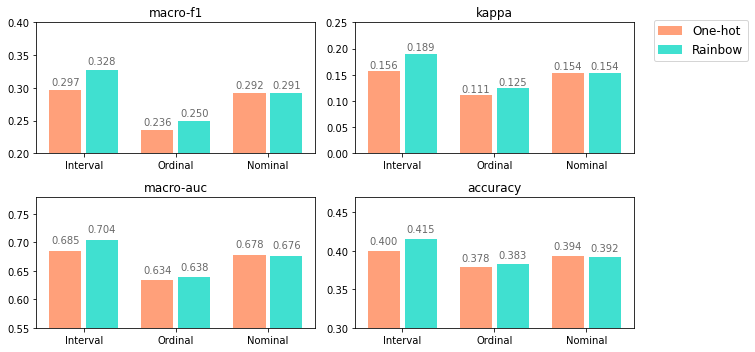

In [6]:
#hide_input
table2 = u.reset_index()
table12 = table2[['method','macro-f1','accuracy','kappa','macro-auc']].round(4)

def autolabel(rects, i, j, decimals=3):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        axs[i, j].text(rect.get_x() + rect.get_width()/2., 1.015*height,
                '%.{}f'.format(decimals) % height,
                ha='center', va='bottom', color = 'dimgrey')  

def make_subplot2(table12, metric, x, i, j, colors, ylimits=[]):
    y1 = table12[table12['method']=='One-hot'][metric].reset_index(drop=True)
    y2 = table12[table12['method']=='Rainbow'][metric].reset_index(drop=True)
    rects1 = axs[i, j].bar(x-0.2, y1, width, label = 'One-hot', color = colors[0])
    rects2 = axs[i, j].bar(x+0.2, y2, width, label = 'Rainbow', color = colors[1]) 
    axs[i, j].set_ylim(ylimits)
    axs[i, j].set_xticks(x)    
    axs[i, j].set_xticklabels(['Interval', 'Ordinal', 'Nominal'], rotation=0)
    axs[i, j].set_title(metric)
    autolabel(rects1, i, j)
    autolabel(rects2, i, j)

x = np.arange(3)
fig, axs = plt.subplots(2, 2, figsize=(9,5))
width = 0.35
colors = ['lightsalmon', 'turquoise']
make_subplot2(table12, 'macro-f1', x, 0, 0, colors, [0.2,0.40])
make_subplot2(table12, 'kappa', x, 0, 1, colors, [0, 0.25])
make_subplot2(table12, 'macro-auc', x, 1, 0, colors, [0.55, 0.78])
make_subplot2(table12, 'accuracy', x, 1, 1, colors, [0.3, 0.47])
fig.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 2.4), loc='upper left', prop={'size': 12})
plt.show()

These results demonstrate again that Rainbow is preferred to One-hot. As expected, interval and ordinal features gain the most from Rainbow encoding - less so for nominal variables.

Clearly, the more defined category order, the higher the benefits of preferring Rainbow to One-hot. For nominal variables, model performance is about the same or negligibly lower for Rainbow than for One-hot. However, even in that case, that same performance is achieved in hugely less time, by using substantially less space, and the resulting model is significantly simpler.

## Feature Selection

Finally, to make a comparison fairer in terms of dimensionality, we picked top 10, top 50, and top 100 features from each feature set (Rainbow and One-hot). We used the feature importance attribute of the XGBoost model and aggregated feature importance scores for 4 cross-validation folds on the best hyperparameter set for each encoding type. Below are the results.

In [7]:
#hide
feature_selection = pd.read_csv('rainbow_research_feature_selection.csv').rename(columns={'feature_selection_parameter':'Num_features',"transform_parameter": "method"})
metrics=['accuracy', 'kappa', 'macro avg_f1-score', 'weighted avg_f1-score', 'macro avg_roc_auc', 'weighted avg_roc_auc']
tmp = feature_selection.groupby(['Num_features', 'method'])[metrics].mean().round(4).reset_index()
tmp['Num_features']=tmp['Num_features'].str.replace('top_',"").astype(int)
table1 = tmp.set_index(['Num_features', 'method']).sort_index()
table1=table1.rename(columns={'macro avg_f1-score': 'macro-f1',
                       'weighted avg_f1-score':'weighted-f1',
                       'macro avg_roc_auc':'macro-auc',
                       'weighted avg_roc_auc' : 'weighted-auc'
                      })
table1[['macro-f1','accuracy','kappa','macro-auc']].round(2)
table11 = table1[['macro-f1','accuracy','kappa','macro-auc']].round(4).reset_index()


# same as below, but just the table - chart is a nicer representation
w = table1[['macro-f1', 'kappa', 'macro-auc', 'accuracy']].reset_index().replace({'one_hot': 'One-hot', 'rainbow': 'Rainbow'})
w = w.set_index(['Num_features', 'method'])
w.index.set_names(['number of features', 'method'], inplace=True)
w

macro-f1   kappa  macro-auc  accuracy
number of features method                                        
10                 One-hot    0.2685  0.1505     0.6778    0.3945
                   Rainbow    0.3308  0.1980     0.7062    0.4220
50                 One-hot    0.3270  0.1925     0.7042    0.4172
                   Rainbow    0.3448  0.2120     0.7182    0.4298
100                One-hot    0.3358  0.2002     0.7100    0.4215
                   Rainbow    0.3405  0.2078     0.7190    0.4265

Figure 6

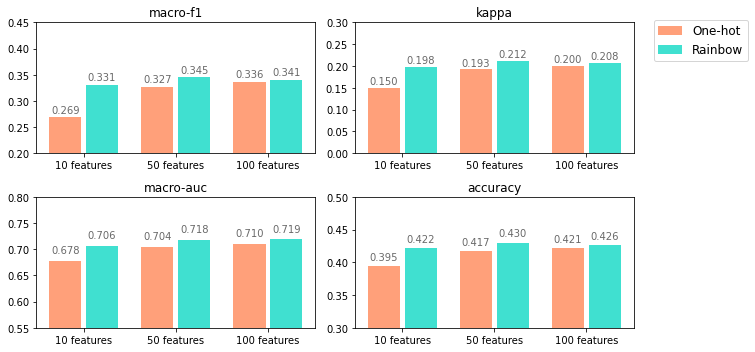

In [8]:
#hide_input

def make_subplot(table11, metric, x, i, j, colors, ylimits=[]):
    y1 = table11[table11['method']=='one_hot'][metric]
    y2 = table11[table11['method']=='rainbow'][metric]
    rects1 = axs[i, j].bar(x-0.2, y1, width, label = 'One-hot', color = colors[0])
    rects2 = axs[i, j].bar(x+0.2, y2, width, label = 'Rainbow', color = colors[1]) 
    axs[i, j].set_ylim(ylimits)
    axs[i, j].set_xticks(x)    
    axs[i, j].set_xticklabels(['10 features', '50 features', '100 features'], rotation=0)
    axs[i, j].set_title(metric)
    autolabel(rects1, i, j)
    autolabel(rects2, i, j)
    

x = np.arange(3)
fig, axs = plt.subplots(2, 2, figsize=(9,5))
width = 0.35
colors = ['lightsalmon', 'turquoise']
make_subplot(table11, 'macro-f1', x, 0, 0, colors, [0.2,0.45])
make_subplot(table11, 'kappa', x, 0, 1, colors, [0, 0.30])
make_subplot(table11, 'macro-auc', x, 1, 0, colors, [0.55, 0.80])
make_subplot(table11, 'accuracy', x, 1, 1, colors, [0.3, 0.50])
fig.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 2.4), loc='upper left', prop={'size': 12})
plt.show()

The rainbow method outperforms the One-hot easily. Especially, for small number of features. Rainbow reaches peak performance more quickly than One-hot, using fewer features - Rainbow is already near peak with only 10 features while it takes one-hot 50-100 features to reach similar level!

Rainbow even shows better results for 50 features than One-hot does for 100. Also note that when dropping from 50 to 10 features, the reduction in Macro-F1 if you use One-hot is 6 times that of the rainbow method (3 times for Kappa and Accuracy, 2 times for Macro-AUC).

## Conclusion

In the example of Mindset Segmentation model at MassMutual, we have illustrated that ordinal encoding via Rainbow method is better than One-hot encoding. It saves a great amount of time for modelers, substantially reduces dimensionality, and provides an organic framework for feature selection. If the chosen rainbow order agrees with data generating process, this encoding also contributes to notable improvements in model performance metrics.

In [Part III](link) we provide mathematical justification to these empirical results, and formally demonstrate the advantages of the Rainbow ordinal encoding method over One-hot for tree-based algorithms.